In [1]:
import lightgbm as lgb, catboost as cat
from pytorch_implementation.dataset import Dataset
from pytorch_implementation.helper_funcs import *

In [2]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import KFold

In [3]:
np.random.seed(42)
random.seed(42)

In [4]:
def read_merge_data(data_type="training"):
    #
    Dfs = []
    train_df = []
    train_output = pd.read_csv("./data_phase_one/training_output.csv", header=None)
    print("Train output:", train_output.shape)
    coords = pd.read_csv("data_phase_one/coords.csv", header=None)
    for name in ["mslp", "sst", "ssta", "t2m"]:
        df = pd.read_csv(f"./data_phase_one/{data_type}_input_{name}.csv", header=None)
        print("Shape df", df.shape)
        Dfs.append(df)
    j = 0
    for i in range(0, df.shape[0]-12, 1):
        feat = pd.concat([coords, Dfs[0].iloc[i:i+12], Dfs[1].iloc[i:i+12], Dfs[2].iloc[i:i+12], Dfs[3].iloc[i:i+12]], axis=0).reset_index(drop=True)
        tgt = train_output.iloc[i+11]
        tgt = tgt.T.reset_index(drop=True)
        feat = feat.T.reset_index(drop=True)
        feat = pd.concat([feat, tgt], axis=1)
        assert feat.shape[1]==51
        feat.columns = [f"feat_{k}" for k in range(feat.shape[1]-1)] + ["target"]
        if j < 3:
            print(feat.columns)
        train_df.append(feat)
        j += 1
    train_df = pd.concat(train_df, axis=0)
    #Dfs.index = [f"col_{i}" for i in range(848)]
    return train_df

In [5]:
data = read_merge_data()

Train output: (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49', 'target'],
      dtype='object')
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat

In [6]:
cv = KFold(n_splits=5, shuffle=True)

In [7]:
params_lgb = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "max_depth": 8,
    'num_leaves': 255,
    "learning_rate": 0.01,
    "n_estimators": 2000,
    #"colsample_bytree": 0.8, 
    #"colsample_bynode": 0.8,
    "verbose": -1,
    "device": "cpu",
    #"gpu_device_id": 1
}

In [8]:
params_catb = dict(
task_type="CPU",
devices='1',
reg_lambda=0.438, learning_rate=0.1,
max_depth=8, min_data_in_leaf=50,
n_estimators=2000, verbose=50,
objective='RMSE')

In [9]:
for state, (train_idx, val_idx) in enumerate(cv.split(data)):
    X_train = data.drop(columns=["target"]).iloc[train_idx].values
    X_val = data.drop(columns=["target"]).iloc[val_idx].values
    y_train = data["target"].iloc[train_idx].values
    y_val = data["target"].iloc[val_idx].values
    if state==3:
        break

In [10]:
for state, (train_idx, val_idx) in enumerate(cv.split(data)):
    X_train = data.drop(columns=["target"]).iloc[train_idx].values
    X_val = data.drop(columns=["target"]).iloc[val_idx].values
    y_train = data["target"].iloc[train_idx].values
    y_val = data["target"].iloc[val_idx].values
    print(f"\nTrain: {len(y_train)}, Val: {len(y_val)}\n")
    if state==3:
        break


Train: 3866270, Val: 966568


Train: 3866270, Val: 966568


Train: 3866270, Val: 966568


Train: 3866271, Val: 966567



In [11]:
val_idx

array([      5,       6,      16, ..., 4832835, 4832836, 4832837])

In [12]:
lgb_model = joblib.load('kfold_trained2/lgb_model_fold3.joblib')
catb_model = joblib.load('kfold_trained2/catb_model_fold3.joblib')
trained_nn_models = load_trained2("./trained_models_nn")
lstm_model = trained_nn_models[1::2][-2]
gru_model = trained_nn_models[0::2][-2]

In [18]:
pred_lgb = lgb_model.predict(X_val[:200])
pred_catb = catb_model.predict(X_val[:200])
pred_lstm = average_prediction(X_val[:200], [lstm_model]).squeeze()
pred_gru = average_prediction(X_val[:200], [gru_model]).squeeze()

/home/nkouagou/.conda/envs/ecmldeep/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/nkouagou/.conda/envs/ecmldeep/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [19]:
print("lgbm error:", np.linalg.norm(y_val[:200]-pred_lgb))
print("catboost error:", np.linalg.norm(y_val[:200]-pred_catb))
print("lstm error:", np.linalg.norm(y_val[:200]-pred_lstm))
print("gru error:", np.linalg.norm(y_val[:200]-pred_gru))

lgbm error: 4.9075139671989865
catboost error: 4.898022568338716
lstm error: 5.280148550357366
gru error: 5.124149924302574


In [21]:
import matplotlib.pyplot as plt

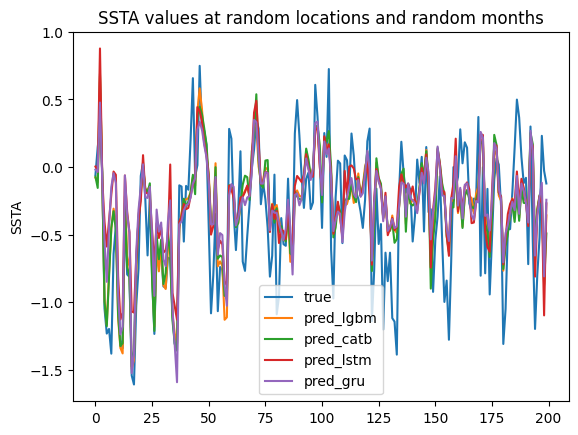

In [22]:
plt.plot(y_val[:200])
plt.plot(pred_lgb)
plt.plot(pred_catb)
plt.plot(pred_lstm)
plt.plot(pred_gru)
plt.legend(["true", "pred_lgbm", "pred_catb", "pred_lstm", "pred_gru"])
plt.ylabel('SSTA')
plt.title('SSTA values at random locations and random months')
plt.savefig('random_preds.pdf', bbox_inches='tight')
plt.show()